In [1]:
import os
import sys

#sys.path.append('../')

import ot
import torch  # noqa: E402
import pickle  # noqa: E402
import random  # noqa: E402
import numpy as np  # noqa: E402
import seaborn as sns
import pytorch_lightning as pl  # noqa: E402
import matplotlib.pyplot as plt

from Online_GMM import Online_GMM

from pydil.ipms.ot_ipms import (  # noqa: E402
    JointWassersteinDistance
)
from pydil.dadil.labeled_dictionary import LabeledDictionary  # noqa: E402
from pydil.dadil.labeled_dictionary_GMM import LabeledDictionaryGMM
from pydil.ot_utils.barycenters import wasserstein_barycenter  # noqa: E402
from pydil.torch_utils.measures import (  # noqa: E402
    UnsupervisedDatasetMeasure,
    SupervisedDatasetMeasure
)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import importlib

C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())
C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = np.load(r'C:\Users\SL276123\Documents\Online DaDiL\CSTR\data\cstr_acfmeandata.npy')

In [3]:
dataset.shape

(2860, 18)

In [4]:
X = dataset[:, :-4]
y = dataset[:, -4]
d = dataset[:, -3]

n_domains = int(np.max(d)) + 1
n_features = X.shape[1]

In [5]:
X.shape, y.shape, d.shape

((2860, 14), (2860,), (2860,))

In [6]:
Xs, ys = [], []
for i in range(n_domains-1):
    Xs.append(torch.from_numpy(X[np.where(d == i)[0]]).float())
    ys.append(torch.from_numpy(y[np.where(d == i)[0]]).float())

In [7]:
Xt = torch.from_numpy(X[np.where(d == n_domains-1)[0]]).float()
yt = torch.from_numpy(y[np.where(d == n_domains-1)[0]]).float()

In [8]:
n_samples = 1300
batch_size = 260
n_components = 3

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_t = torch.from_numpy(X_train)
X_test_t = torch.from_numpy(X_test)
X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[np.where(d==6)[0], :], y[np.where(d==6)[0]], test_size=0.2, random_state=0)
X_train_target_t = torch.from_numpy(X_train_target)
X_test_target_t = torch.from_numpy(X_test_target)

In [10]:
range_data = np.mean(np.max(X[np.where(d!=6)[0], :], axis=0) - np.min(X[np.where(d!=6)[0], :], axis=0))

dim_reduction = 3
K_max = 13
OGMM = Online_GMM(
    n_components=K_max, 
    lr=0.1,
    n_features=dim_reduction,
    data_range=range_data,
    batch_size=batch_size
)

i=0
while i < Xt.shape[0]-dim_reduction:
    OGMM.fit_sample_with_dim_reduction(Xt[i:i+dim_reduction, :])
    i += dim_reduction

OGMM.generate_list()

c:\Users\SL276123\Documents\Online DaDiL\PyDiL-main\PyDiL-main\Online_GMM.py:89: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  return (2*np.pi)**(-len(x)/2) * np.linalg.det(cov)**(-1/2) * np.exp(-1/2 * (x - mean).T @ np.linalg.inv(cov) @ (x - mean))


[[tensor(3.7446e-06),
  tensor(23.5341),
  tensor([ 0.2566, -0.0072,  0.0018]),
  tensor([[ 8.7732e-04, -8.1179e-06, -4.3610e-05],
          [-8.1179e-06,  1.6886e-04,  1.0428e-04],
          [-4.3610e-05,  1.0428e-04,  4.0313e-04]])],
 [tensor(8.4565e-11),
  tensor(18.0840),
  tensor([-0.3460, -0.0053,  0.0118]),
  tensor([[ 0.0042,  0.0004, -0.0010],
          [ 0.0004,  0.0013,  0.0002],
          [-0.0010,  0.0002,  0.0014]])],
 [tensor(9.6604e-08),
  tensor(6.9066),
  tensor([-0.5394,  0.4402,  0.0554]),
  tensor([[ 0.0214,  0.0068, -0.0184],
          [ 0.0068,  0.0124,  0.0016],
          [-0.0184,  0.0016,  0.0283]])],
 [tensor(0.0001),
  tensor(11.3709),
  tensor([0.1283, 0.5368, 0.0433]),
  tensor([[0.0109, 0.0077, 0.0068],
          [0.0077, 0.0169, 0.0182],
          [0.0068, 0.0182, 0.0217]])],
 [tensor(6.7955e-07),
  tensor(3.4565),
  tensor([ 0.0818, -0.4050,  0.5018]),
  tensor([[ 0.0039, -0.0060,  0.0122],
          [-0.0060,  0.0280, -0.0521],
          [ 0.0122, -0.0

Test to determine the best K_max

In [11]:
%%script false --no-exec
range_data = np.mean(np.max(X[np.where(d!=6)[0], :], axis=0) - np.min(X[np.where(d!=6)[0], :], axis=0))

K_max = np.linspace(13, 63, 11)
ll = []
for kmax in K_max:
    OGMM = Online_GMM(
        n_components=kmax, 
        lr=0.1,
        n_features=dim_reduction,
        data_range=range_data,
        batch_size=batch_size
    )
    
    i = 0
    while i < X_train_target_t.shape[0]-dim_reduction:
        OGMM.fit_sample_with_dim_reduction(X_train_target_t[i:i+dim_reduction, :])
        i += dim_reduction

    print(OGMM.generate_list())
    ll.append(OGMM.log_likelihood_with_dim_reduction(X_test_target_t))

Couldn't find program: 'false'


## Dictionary learning seperated between sources and target

In [12]:
Q_sources = []
for Xs_k, ys_k in zip(Xs, ys):
    Q_sources.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q_target = [OGMM]

In [13]:
criterion = JointWassersteinDistance()

In [14]:
dictionary_sources = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q_sources),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [15]:
dictionary_sources.fit(Q_sources,
               n_iter_max=30,
               batches_per_it=n_samples // batch_size,
               verbose=True)

100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


It 0/30, Loss: 104.60241394042968


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


It 1/30, Loss: 47.376792144775386


100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


It 2/30, Loss: 20.183803939819335


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


It 3/30, Loss: 9.122239494323733


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


It 4/30, Loss: 4.671039295196533


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


It 5/30, Loss: 2.7290884494781493


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


It 6/30, Loss: 1.8457133769989014


100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


It 7/30, Loss: 1.3818926334381103


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


It 8/30, Loss: 1.0562419056892394


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


It 9/30, Loss: 0.8403161406517028


100%|██████████| 5/5 [00:09<00:00,  1.82s/it]


It 10/30, Loss: 0.7223891496658326


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


It 11/30, Loss: 0.6412389397621154


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


It 12/30, Loss: 0.5955076575279236


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


It 13/30, Loss: 0.5494281053543091


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


It 14/30, Loss: 0.5213353872299195


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


It 15/30, Loss: 0.5051303982734681


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


It 16/30, Loss: 0.4917357385158539


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


It 17/30, Loss: 0.4910605847835541


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


It 18/30, Loss: 0.47314885258674616


100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


It 19/30, Loss: 0.4625597059726715


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


It 20/30, Loss: 0.42553620934486386


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


It 21/30, Loss: 0.4097723484039307


100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


It 22/30, Loss: 0.383955979347229


100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


It 23/30, Loss: 0.3328358232975006


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


It 24/30, Loss: 0.2985868394374847


100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


It 25/30, Loss: 0.26489423513412474


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


It 26/30, Loss: 0.23780458569526672


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


It 27/30, Loss: 0.22765207886695865


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


It 28/30, Loss: 0.20653438270092012


100%|██████████| 5/5 [00:08<00:00,  1.65s/it]

It 29/30, Loss: 0.21897457540035248


In [16]:
XP_sources = dictionary_sources.XP
YP_sources = dictionary_sources.YP

In [17]:
names_sources = [f'domain {i}' for i in range(6)]

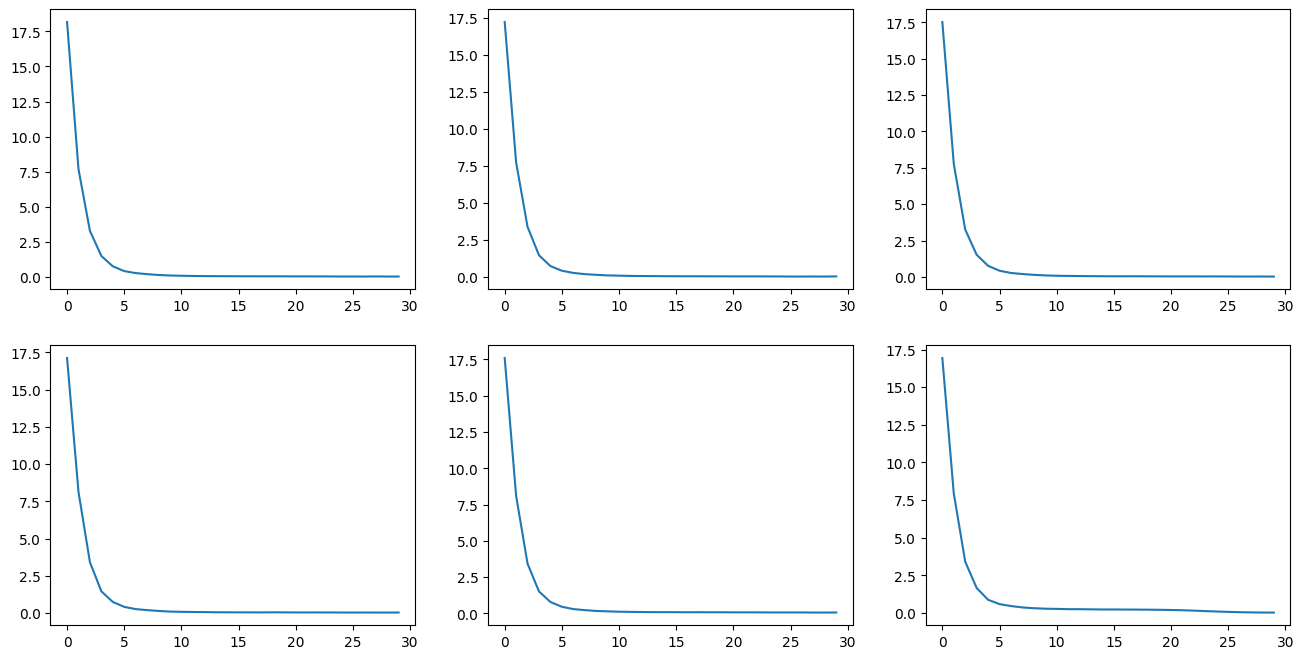

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, d in enumerate(dictionary_sources.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary_sources.history['loss_per_dataset'][d])

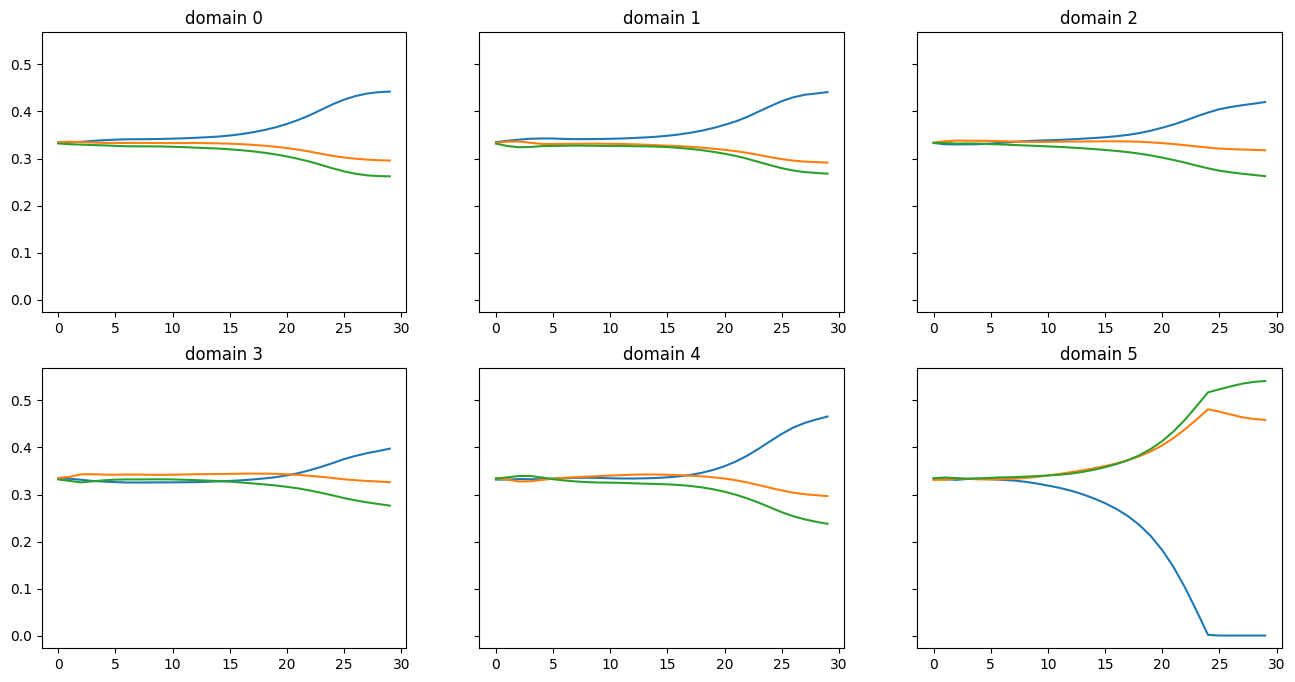

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names_sources, axes.flatten())):
    ax.plot(torch.stack(dictionary_sources.history['weights'])[:, k, :])
    ax.set_title(name)

In [32]:
dictionary_target = LabeledDictionaryGMM(XP=XP_sources,
                           YP=YP_sources,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q_target),
                           loss_fn=criterion,
                           learning_rate_features=1e-3,
                           learning_rate_labels=1e-3,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [33]:
dictionary_target.fit(Q_target,
               n_iter_max=30,
               batches_per_it=n_samples // batch_size,
               verbose=True,
               regularization=True)

100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


It 0/30, Loss: 0.1809426039457321


100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


It 1/30, Loss: 0.1797188699245453


100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


It 2/30, Loss: 0.17626446187496184


100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


It 3/30, Loss: 0.16844801008701327


100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


It 4/30, Loss: 0.16008855104446412


100%|██████████| 5/5 [00:01<00:00,  3.61it/s]


It 5/30, Loss: 0.1568720370531082


100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


It 6/30, Loss: 0.14993611574172974


100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


It 7/30, Loss: 0.14821641147136688


100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


It 8/30, Loss: 0.14825209081172944


100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


It 9/30, Loss: 0.1385491043329239


100%|██████████| 5/5 [00:01<00:00,  3.61it/s]


It 10/30, Loss: 0.1341026693582535


100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


It 11/30, Loss: 0.1269630879163742


100%|██████████| 5/5 [00:01<00:00,  4.04it/s]


It 12/30, Loss: 0.11925608515739441


100%|██████████| 5/5 [00:01<00:00,  3.99it/s]


It 13/30, Loss: 0.11430494189262388


100%|██████████| 5/5 [00:01<00:00,  3.88it/s]


It 14/30, Loss: 0.11065263152122498


100%|██████████| 5/5 [00:01<00:00,  4.03it/s]


It 15/30, Loss: 0.11236046850681305


100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


It 16/30, Loss: 0.10734242498874663


100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


It 17/30, Loss: 0.10023389458656311


100%|██████████| 5/5 [00:01<00:00,  4.00it/s]


It 18/30, Loss: 0.09502286463975906


100%|██████████| 5/5 [00:01<00:00,  3.60it/s]


It 19/30, Loss: 0.09100541472434998


100%|██████████| 5/5 [00:01<00:00,  2.84it/s]


It 20/30, Loss: 0.08873061835765839


100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


It 21/30, Loss: 0.08571781367063523


100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


It 22/30, Loss: 0.08446947932243348


100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


It 23/30, Loss: 0.07872469276189803


100%|██████████| 5/5 [00:01<00:00,  3.76it/s]


It 24/30, Loss: 0.07731932252645492


100%|██████████| 5/5 [00:01<00:00,  3.73it/s]


It 25/30, Loss: 0.07713798880577089


100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


It 26/30, Loss: 0.07496272325515747


100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


It 27/30, Loss: 0.07332807928323745


100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


It 28/30, Loss: 0.07263933569192886


100%|██████████| 5/5 [00:01<00:00,  3.15it/s]

It 29/30, Loss: 0.06943681240081787


In [34]:
target_name = 'Domain 7'

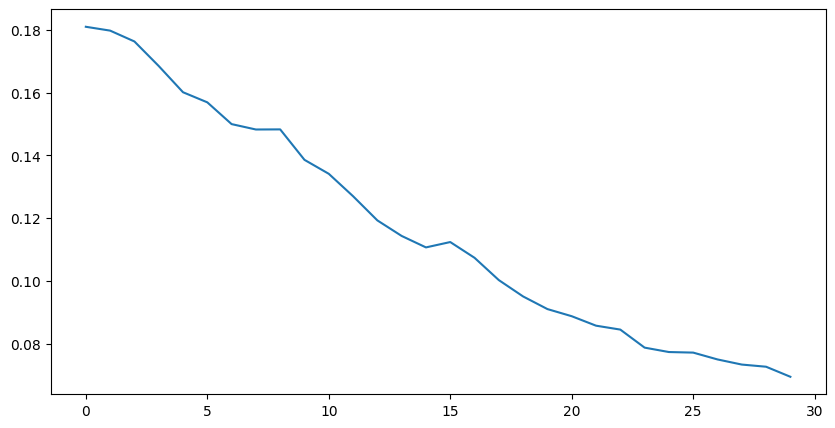

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dictionary_target.history['loss_per_dataset']['Domain 0'])

Text(0.5, 1.0, 'Domain 7')

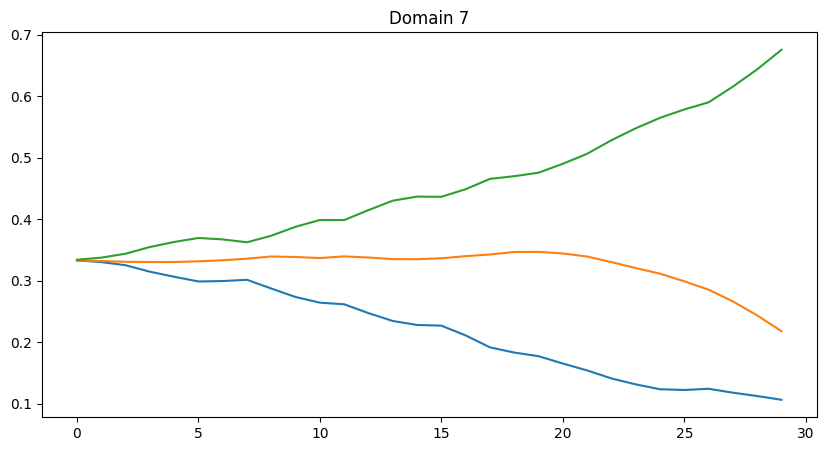

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(torch.stack(dictionary_target.history['weights'])[:, 0, :])
ax.set_title(target_name)

In [37]:
weights = dictionary_target.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary_target.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary_target.YP]

tensor([0.1066, 0.2180, 0.6754])


In [38]:
Xr, Yr = wasserstein_barycenter(
    XP=XP,
    YP=YP,
    n_samples=n_samples,
    weights=weights,
    tol=1e-9,
    n_iter_max=10,
    propagate_labels=True,
    penalize_labels=True
)

Classification without DA

In [39]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'log_loss')
clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.6038461538461538


DaDiL-E

In [40]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier(criterion = 'log_loss')
predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.10700000077486038 got 0.40384615384615385
Atom 1 w/ weight 0.21799999475479126 got 0.4576923076923077
Atom 2 w/ weight 0.675000011920929 got 0.5615384615384615
0.5423076923076923


DaDiL-R

In [41]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'log_loss')
clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.5076923076923077


## Classic Dictionary Learning

In [15]:
Q = []
for Xs_k, ys_k in zip(Xs, ys):
    Q.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q.append(OGMM)

In [21]:
criterion = JointWassersteinDistance()

In [17]:
dictionary = LabeledDictionary(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [ ]:
dictionary.fit(Q,
               n_iter_max=60,
               batches_per_it=n_samples // batch_size,
               verbose=True)

In [ ]:
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

(0.0, 1.0, 0.0, 1.0)

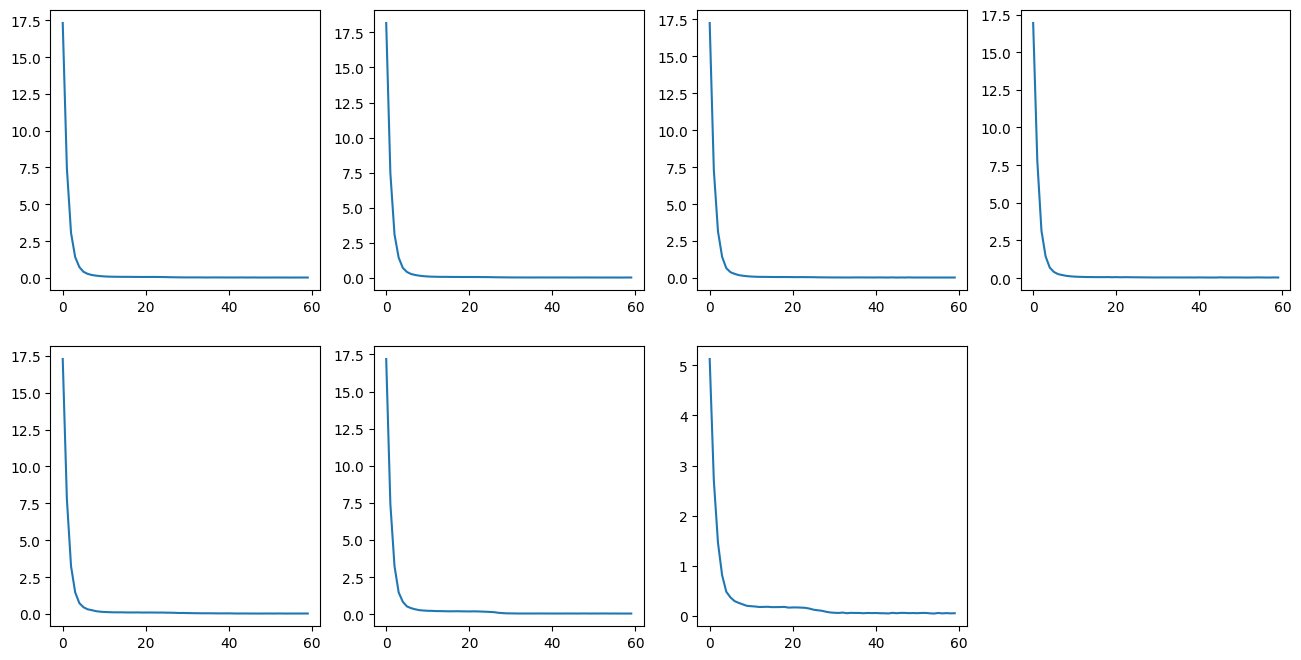

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for k, d in enumerate(dictionary.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary.history['loss_per_dataset'][d])
axes.flatten()[-1].axis('off')

(0.0, 1.0, 0.0673781655728817, 0.7154823370277882)

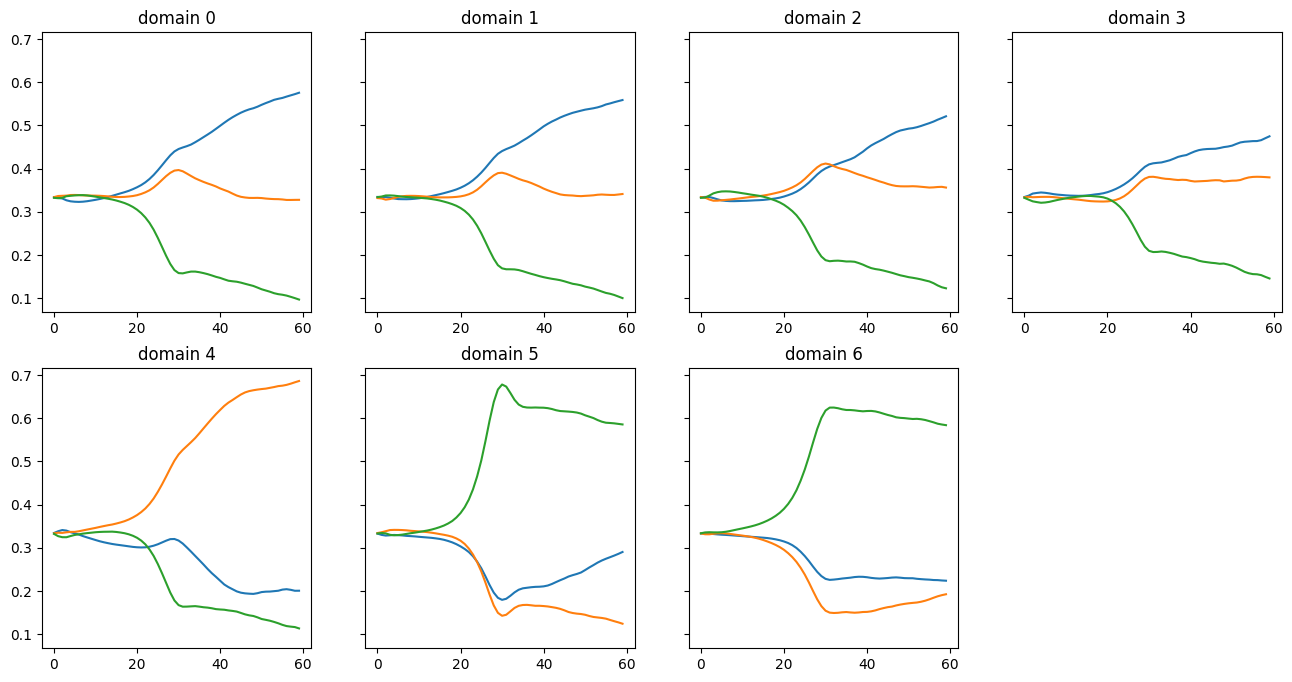

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names, axes.flatten())):
    ax.plot(torch.stack(dictionary.history['weights'])[:, k, :])
    ax.set_title(name)
axes.flatten()[-1].axis('off')

In [ ]:
weights = dictionary.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary.YP]

tensor([0.2238, 0.1924, 0.5838])


In [ ]:
Xr, Yr = wasserstein_barycenter(
    XP=XP,
    YP=YP,
    n_samples=n_samples,
    weights=weights,
    tol=1e-9,
    n_iter_max=10,
    propagate_labels=True,
    penalize_labels=True
)

In [ ]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'log_loss')
clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.6038461538461538


In [ ]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier(criterion = 'log_loss')
predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.328000009059906 got 0.5615384615384615
Atom 1 w/ weight 0.33899998664855957 got 0.33076923076923076
Atom 2 w/ weight 0.33399999141693115 got 0.6692307692307692
0.6076923076923076


In [ ]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'log_loss')
clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.5923076923076923
